# Base experiment notebook

This notebook is the template for all experiments.

It contains the basic code to run an experiment, and it is the starting point for all other notebooks in the folder `experiments`.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from pytorch_lightning import callbacks, seed_everything
from tensorboard.backend.event_processing import event_accumulator
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    calculate_metrics_binary,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_precision_recall_curve_binary,
    plot_roc_curve,
    plot_roc_curve_binary,
)

In [3]:
seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

## Definition of the notebook variables

In [4]:
# To change between experiments
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

BATCH_SIZE = 512
MAX_EPOCHS = 50


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False


### Definition of the net architecture
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, n_classes=2, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, inter_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits


MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
INPUT_DIM = 768
HIDDEN_DIM = 768
NUM_CLASSES = 2
DROPOUT = 0.2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = True
MIN_DELTA = 0.001

## Adam

### Experiment definition

In [20]:
OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

# SCHEDULER_KWARGS = {
#     "scheduler": "ReduceLROnPlateau",
#     "monitor": "val_loss",
#     "mode": "min",
#     "factor": 0.1,
# }

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.9,
}

POSTFIX = "ExponentialLR-0.9"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [18]:
trainer.fit(lit_model);

Missing logger folder: ../../results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0 

Output()

Metric val_loss improved. New best score: 0.567
Epoch 0, global step 306: 'val_loss' reached 0.56682 (best 0.56682), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.554
Epoch 1, global step 612: 'val_loss' reached 0.55397 (best 0.55397), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.542
Epoch 2, global step 918: 'val_loss' reached 0.54189 (best 0.54189), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.534
Epoch 3, global step 1224: 'val_loss' reached 0.53388 (best 0.53388), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.528
Epoch 4, global step 1530: 'val_loss' reached 0.52822 (best 0.52822), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.521
Epoch 5, global step 1836: 'val_loss' reached 0.52052 (best 0.52052), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.517
Epoch 6, global step 2142: 'val_loss' reached 0.51707 (best 0.51707), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.514
Epoch 7, global step 2448: 'val_loss' reached 0.51374 (best 0.51374), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.510
Epoch 8, global step 2754: 'val_loss' reached 0.51002 (best 0.51002), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.507
Epoch 9, global step 3060: 'val_loss' reached 0.50738 (best 0.50738), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.506
Epoch 10, global step 3366: 'val_loss' reached 0.50552 (best 0.50552), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.504
Epoch 11, global step 3672: 'val_loss' reached 0.50415 (best 0.50415), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.502
Epoch 12, global step 3978: 'val_loss' reached 0.50152 (best 0.50152), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.500
Epoch 13, global step 4284: 'val_loss' reached 0.49968 (best 0.49968), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' reached 0.49888 (best 0.49888), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.497
Epoch 16, global step 5202: 'val_loss' reached 0.49742 (best 0.49742), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' reached 0.49691 (best 0.49691), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.496
Epoch 19, global step 6120: 'val_loss' reached 0.49640 (best 0.49640), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=19-step=6120.ckpt' as top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' reached 0.49625 (best 0.49625), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=23-step=7344.ckpt' as top 1


Epoch 24, global step 7650: 'val_loss' reached 0.49607 (best 0.49607), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=24-step=7650.ckpt' as top 1


Epoch 25, global step 7956: 'val_loss' reached 0.49579 (best 0.49579), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=25-step=7956.ckpt' as top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Epoch 31, global step 9792: 'val_loss' was not in top 1


Epoch 32, global step 10098: 'val_loss' was not in top 1


Epoch 33, global step 10404: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.496. Signaling Trainer to stop.
Epoch 34, global step 10710: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=25-step=7956.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adam_0.001_ExponentialLR-0.9/lightning_logs/epoch=25-step=7956.ckpt


Output()

Metrics:  {'log_loss': 0.49040826451621083, 'accuracy': 0.7533562951193764, 'balanced_accuracy': 0.741536230763385, 'recall': 0.669139012081358, 'precision': 0.7211966375473875, 'f1_score': 0.6941932413136602, 'AUC': 0.8346122152503044, 'jaccard_weighted': 0.5316201931838892, 'matthews_weighted': 0.4889782096890578, 'hamming_loss': 0.2466437048806236, 'confusion_matrix': [[44396, 10149], [12981, 26253]], 'confusion_matrix_true_normed': [[0.813933449445412, 0.18606655055458796], [0.330860987918642, 0.669139012081358]], 'confusion_matrix_pred_normed': [[0.7737595203653032, 0.2788033624526125], [0.22624047963469682, 0.7211966375473875]], 'confusion_matrix_all_normed': [[0.47341089156420946, 0.10822252316616726], [0.13842118171445633, 0.27994540355516695]]}


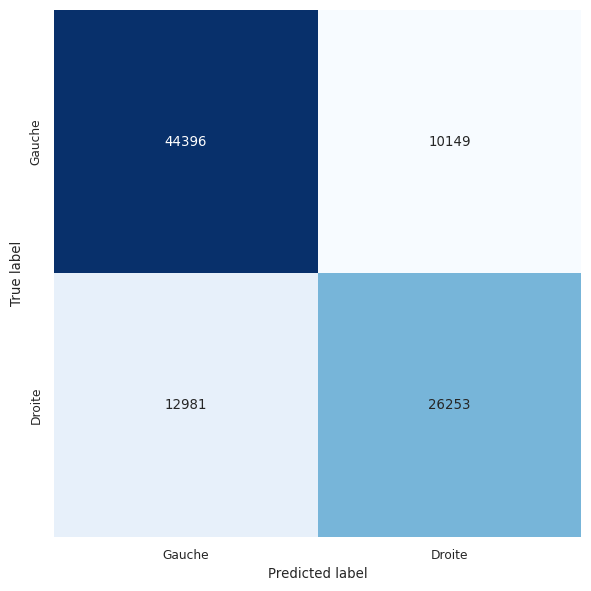

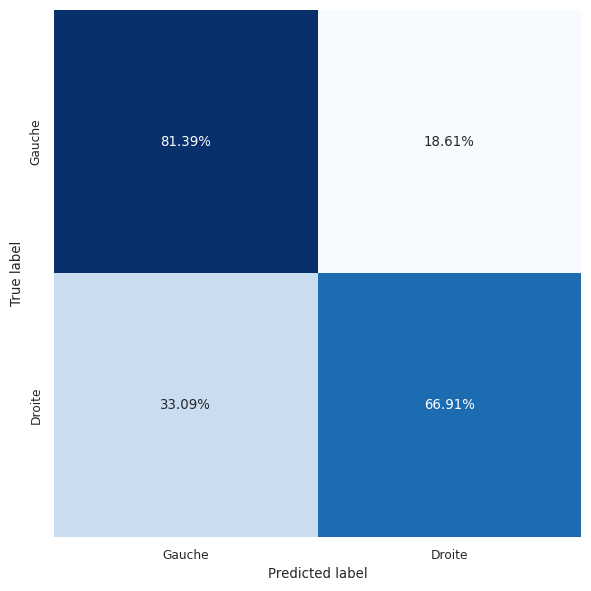

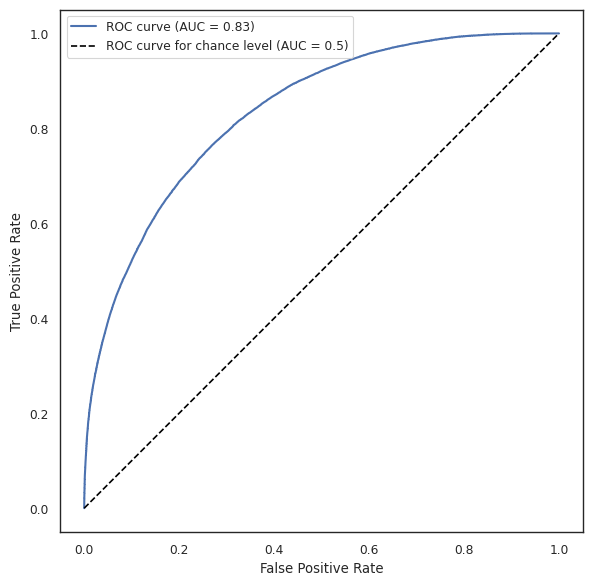

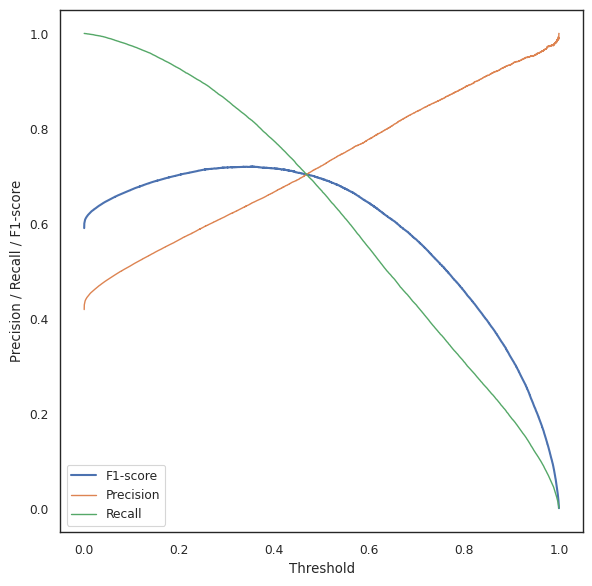

In [19]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## AdamW

### Experiment definition

In [12]:
OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.99,
}

POSTFIX = "ExponentialLR"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [14]:
trainer.fit(lit_model);

Missing logger folder: ../../results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0    

Output()

Metric val_loss improved. New best score: 0.567
Epoch 0, global step 306: 'val_loss' reached 0.56713 (best 0.56713), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.554
Epoch 1, global step 612: 'val_loss' reached 0.55402 (best 0.55402), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.541
Epoch 2, global step 918: 'val_loss' reached 0.54121 (best 0.54121), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.531
Epoch 3, global step 1224: 'val_loss' reached 0.53120 (best 0.53120), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.527
Epoch 4, global step 1530: 'val_loss' reached 0.52743 (best 0.52743), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.522
Epoch 5, global step 1836: 'val_loss' reached 0.52201 (best 0.52201), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.516
Epoch 6, global step 2142: 'val_loss' reached 0.51594 (best 0.51594), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.510
Epoch 7, global step 2448: 'val_loss' reached 0.51045 (best 0.51045), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.506
Epoch 8, global step 2754: 'val_loss' reached 0.50619 (best 0.50619), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' reached 0.50571 (best 0.50571), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.503
Epoch 11, global step 3672: 'val_loss' reached 0.50274 (best 0.50274), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' reached 0.50227 (best 0.50227), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' reached 0.50199 (best 0.50199), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.501
Epoch 15, global step 4896: 'val_loss' reached 0.50053 (best 0.50053), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.501. Signaling Trainer to stop.
Epoch 30, global step 9486: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=15-step=4896.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR/lightning_logs/epoch=15-step=4896.ckpt


Output()

Metrics:  {'log_loss': 0.4944712840641563, 'accuracy': 0.7518954136853666, 'balanced_accuracy': 0.7362451863909796, 'recall': 0.6403884385991742, 'precision': 0.7328705189160809, 'f1_score': 0.6835153773957044, 'AUC': 0.8330246273615209, 'jaccard_weighted': 0.5191973879980162, 'matthews_weighted': 0.48396999507413313, 'hamming_loss': 0.24810458631463334, 'confusion_matrix': [[45387, 9158], [14109, 25125]], 'confusion_matrix_true_normed': [[0.8321019341827849, 0.16789806581721514], [0.35961156140082584, 0.6403884385991742]], 'confusion_matrix_pred_normed': [[0.7628580072609923, 0.26712948108391915], [0.23714199273900766, 0.7328705189160809]], 'confusion_matrix_all_normed': [[0.48397828938248433, 0.09765512534789239], [0.15044946096674094, 0.2679171243028823]]}


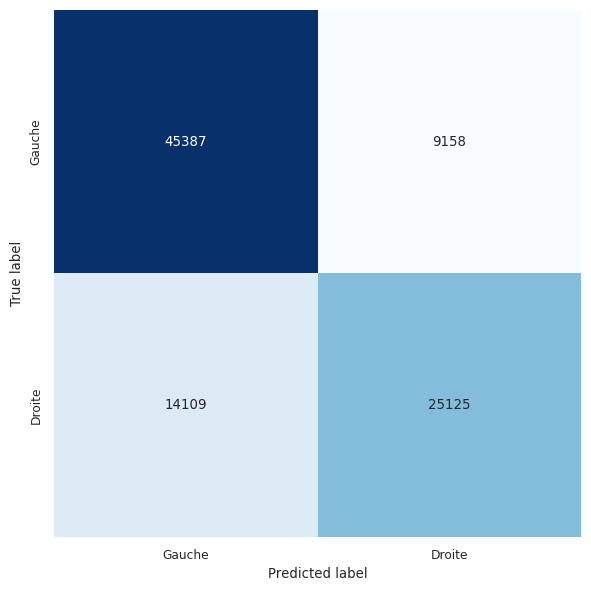

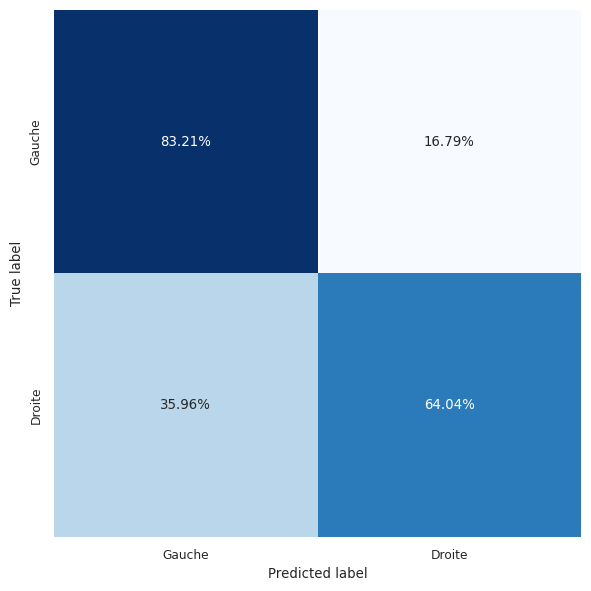

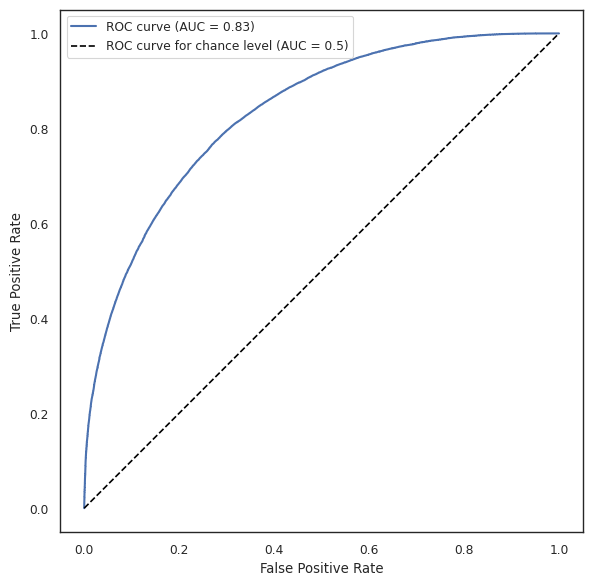

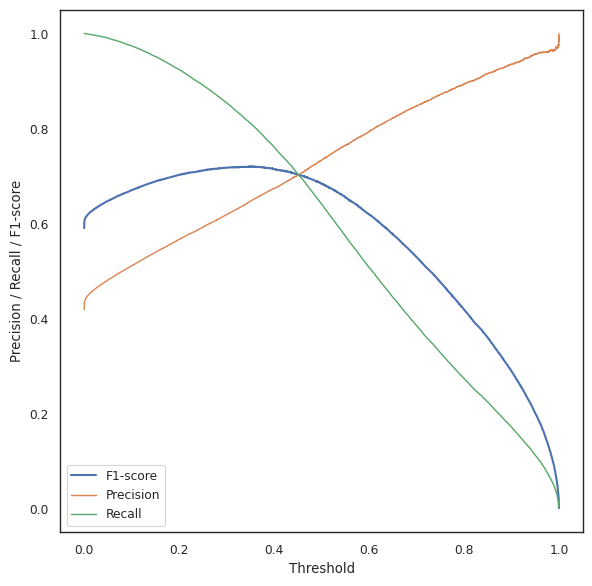

In [15]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## SGD

### Experiment definition

In [16]:
OPTIMIZER_TYPE = "SGD"
OPTIMIZER_KWARGS = {"momentum": 0.9, "nesterov": True, "weight_decay": 0.01}
LR = 5e-2
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "factor": 0.5,
    "patience": 3,
    "monitor": "val_loss",
    "mode": "min",
}
POSTFIX = "NESTEROV"


RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [ ]:
trainer.fit(lit_model, ckpt_path=None);

### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/SGD_0.01_ReduceLROnPlateau/lightning_logs/epoch=49-step=15300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/SGD_0.01_ReduceLROnPlateau/lightning_logs/epoch=49-step=15300.ckpt


Output()

Metrics:  {'log_loss': 0.5968255412084105, 'accuracy': 0.682103669264974, 'balanced_accuracy': 0.6582800476965964, 'recall': 0.5123617270734567, 'precision': 0.6530439867455006, 'f1_score': 0.5742116087751371, 'AUC': 0.734559912665803, 'jaccard_weighted': 0.4027327002444204, 'matthews_weighted': 0.3325497180756659, 'hamming_loss': 0.317896330735026, 'confusion_matrix': [[43865, 10680], [19132, 20102]], 'confusion_matrix_true_normed': [[0.804198368319736, 0.19580163168026402], [0.4876382729265433, 0.5123617270734567]], 'confusion_matrix_pred_normed': [[0.6963029985554867, 0.3469560132544994], [0.3036970014445132, 0.6530439867455006]], 'confusion_matrix_all_normed': [[0.4677486430864053, 0.11388477164397147], [0.2040115590910545, 0.21435502617856877]]}


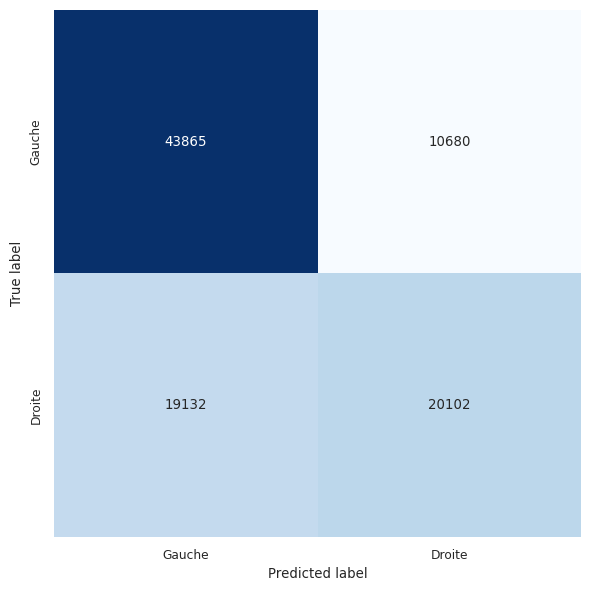

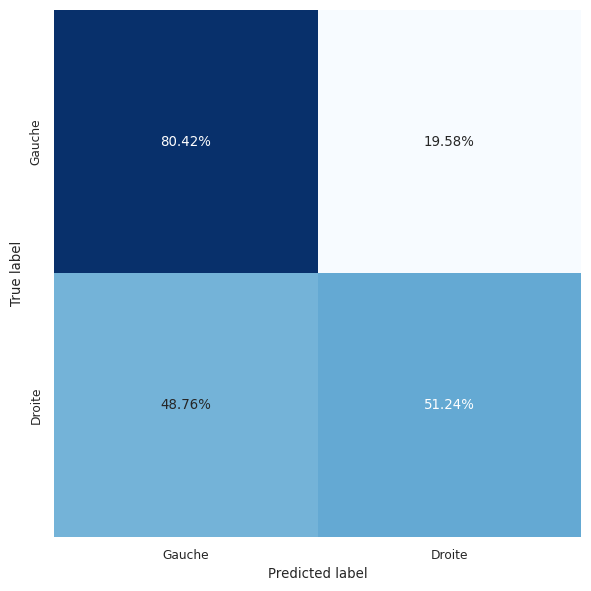

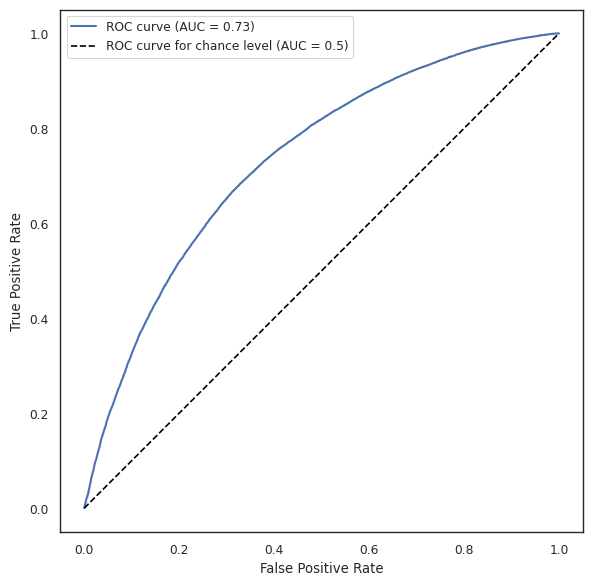

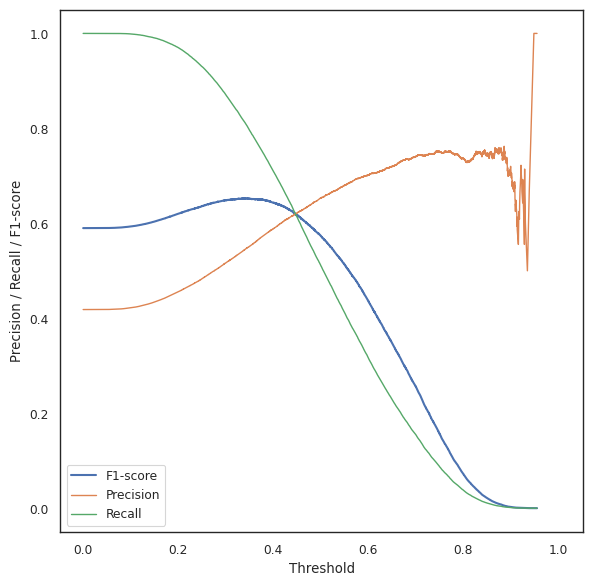

In [9]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## RMSprop

### Experiment definition

In [9]:
OPTIMIZER_TYPE = "RMSprop"
OPTIMIZER_KWARGS = {"weight_decay": 0.005, "momentum": 0.9, "alpha": 0.99}
LR = 1e-2
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.95,
}

POSTFIX = "ExponentialLR"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [10]:
trainer.fit(lit_model);

Missing logger folder: ../../results/optimizer_selection/RMSprop_0.01_ExponentialLR/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0   

Output()

Metric val_loss improved. New best score: 12.796
Epoch 0, global step 306: 'val_loss' reached 12.79555 (best 12.79555), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/RMSprop_0.01_ExponentialLR/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 12.114 >= min_delta = 0.001. New best score: 0.682
Epoch 1, global step 612: 'val_loss' reached 0.68168 (best 0.68168), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/RMSprop_0.01_ExponentialLR/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.678
Epoch 2, global step 918: 'val_loss' reached 0.67844 (best 0.67844), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/RMSprop_0.01_ExponentialLR/lightning_logs/epoch=2-step=918.ckpt' as top 1


Epoch 3, global step 1224: 'val_loss' was not in top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: 
UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Epoch 10/49 ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 144/429 0:00:03 • 0:00:05 59.04it/s loss: 139 v_num: 0 val_loss: 0.747
                                                                                 val_accuracy: 0.593               

### Evaluation and visualization

In [ ]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Adagrad

### Experiment definition

In [11]:
OPTIMIZER_TYPE = "Adagrad"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 3,
    "monitor": "val_loss",
}

POSTFIX = "ReduceLROnPlateau"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [12]:
trainer.fit(lit_model);

Missing logger folder: ../../results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc

Output()

Metric val_loss improved. New best score: 0.596
Epoch 0, global step 306: 'val_loss' reached 0.59636 (best 0.59636), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.588
Epoch 1, global step 612: 'val_loss' reached 0.58800 (best 0.58800), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.585
Epoch 2, global step 918: 'val_loss' reached 0.58482 (best 0.58482), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.583
Epoch 3, global step 1224: 'val_loss' reached 0.58338 (best 0.58338), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.580
Epoch 4, global step 1530: 'val_loss' reached 0.57984 (best 0.57984), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.578
Epoch 5, global step 1836: 'val_loss' reached 0.57840 (best 0.57840), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.576
Epoch 6, global step 2142: 'val_loss' reached 0.57567 (best 0.57567), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Epoch 7, global step 2448: 'val_loss' reached 0.57513 (best 0.57513), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.572
Epoch 8, global step 2754: 'val_loss' reached 0.57193 (best 0.57193), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' reached 0.57161 (best 0.57161), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.570
Epoch 10, global step 3366: 'val_loss' reached 0.57028 (best 0.57028), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Epoch 11, global step 3672: 'val_loss' reached 0.56945 (best 0.56945), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' reached 0.56935 (best 0.56935), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.568
Epoch 13, global step 4284: 'val_loss' reached 0.56849 (best 0.56849), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' reached 0.56828 (best 0.56828), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.567
Epoch 15, global step 4896: 'val_loss' reached 0.56734 (best 0.56734), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' reached 0.56718 (best 0.56718), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Epoch 17, global step 5508: 'val_loss' reached 0.56693 (best 0.56693), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' reached 0.56637 (best 0.56637), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.566
Epoch 19, global step 6120: 'val_loss' reached 0.56622 (best 0.56622), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=19-step=6120.ckpt' as top 1


Epoch 20, global step 6426: 'val_loss' reached 0.56567 (best 0.56567), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=20-step=6426.ckpt' as top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.565
Epoch 22, global step 7038: 'val_loss' reached 0.56515 (best 0.56515), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=22-step=7038.ckpt' as top 1


Epoch 23, global step 7344: 'val_loss' reached 0.56504 (best 0.56504), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=23-step=7344.ckpt' as top 1


Epoch 24, global step 7650: 'val_loss' reached 0.56460 (best 0.56460), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=24-step=7650.ckpt' as top 1


Epoch 25, global step 7956: 'val_loss' reached 0.56438 (best 0.56438), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=25-step=7956.ckpt' as top 1


Epoch 26, global step 8262: 'val_loss' reached 0.56416 (best 0.56416), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=26-step=8262.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.564
Epoch 27, global step 8568: 'val_loss' reached 0.56389 (best 0.56389), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=27-step=8568.ckpt' as top 1


Epoch 28, global step 8874: 'val_loss' reached 0.56365 (best 0.56365), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=28-step=8874.ckpt' as top 1


Epoch 29, global step 9180: 'val_loss' reached 0.56349 (best 0.56349), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=29-step=9180.ckpt' as top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.563
Epoch 31, global step 9792: 'val_loss' reached 0.56285 (best 0.56285), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=31-step=9792.ckpt' as top 1


Epoch 32, global step 10098: 'val_loss' reached 0.56280 (best 0.56280), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=32-step=10098.ckpt' as top 1


Epoch 33, global step 10404: 'val_loss' reached 0.56276 (best 0.56276), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=33-step=10404.ckpt' as top 1


Epoch 34, global step 10710: 'val_loss' reached 0.56246 (best 0.56246), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=34-step=10710.ckpt' as top 1


Epoch 35, global step 11016: 'val_loss' was not in top 1


Epoch 36, global step 11322: 'val_loss' was not in top 1


Epoch 37, global step 11628: 'val_loss' reached 0.56222 (best 0.56222), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=37-step=11628.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.562
Epoch 38, global step 11934: 'val_loss' reached 0.56175 (best 0.56175), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=38-step=11934.ckpt' as top 1


Epoch 39, global step 12240: 'val_loss' reached 0.56159 (best 0.56159), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=39-step=12240.ckpt' as top 1


Exception ignored in: <function _releaseLock at 0x7f08b13d2ef0>
Epoch 40/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:08 • 0:00:00 0.00it/s loss: 0.57 v_num: 0 val_loss: 0.562
                                                                                val_accuracy: 0.704                

Traceback (most recent call last):
Epoch 40/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:08 • 0:00:00 0.00it/s loss: 0.57 v_num: 0 val_loss: 0.562
                                                                                val_accuracy: 0.704                

  File "/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
Epoch 40/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:08 • 0:00:00 0.00it/s loss: 0.57 v_num: 0 val_loss: 0.562
                                                                                val_accuracy: 0.704                

    def _releaseLock():
Epoch 40/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:08 • 0:00:00 0.00it/s loss: 0.57 v_num: 0 val_loss: 0.562
                                                                                val_accuracy: 0.704                

KeyboardInterrupt: 
Epoch 40/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:08 • 0:00:00 0.00it/s loss: 0.57 v_num: 0 val_loss: 0.562
                                                                                val_accuracy: 0.704                

Epoch 40, global step 12546: 'val_loss' reached 0.56119 (best 0.56119), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=40-step=12546.ckpt' as top 1


Epoch 41, global step 12852: 'val_loss' was not in top 1


Exception ignored in: <function _releaseLock at 0x7f08b13d2ef0>
Epoch 42/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:09 • 0:00:00 0.00it/s loss: 0.569 v_num: 0 val_loss:     
                                                                                0.561 val_accuracy: 0.705          

Traceback (most recent call last):
Epoch 42/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:09 • 0:00:00 0.00it/s loss: 0.569 v_num: 0 val_loss:     
                                                                                0.561 val_accuracy: 0.705          

  File "/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
Epoch 42/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:09 • 0:00:00 0.00it/s loss: 0.569 v_num: 0 val_loss:     
                                                                                0.561 val_accuracy: 0.705          

    def _releaseLock():
Epoch 42/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:09 • 0:00:00 0.00it/s loss: 0.569 v_num: 0 val_loss:     
                                                                                0.561 val_accuracy: 0.705          

KeyboardInterrupt: 
Epoch 42/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/429 0:00:09 • 0:00:00 0.00it/s loss: 0.569 v_num: 0 val_loss:     
                                                                                0.561 val_accuracy: 0.705          

Epoch 42, global step 13158: 'val_loss' reached 0.56096 (best 0.56096), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=42-step=13158.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.561
Epoch 43, global step 13464: 'val_loss' reached 0.56067 (best 0.56067), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=43-step=13464.ckpt' as top 1


Epoch 44, global step 13770: 'val_loss' reached 0.56065 (best 0.56065), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=44-step=13770.ckpt' as top 1


Epoch 45, global step 14076: 'val_loss' reached 0.56027 (best 0.56027), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=45-step=14076.ckpt' as top 1


Epoch 46, global step 14382: 'val_loss' was not in top 1


Epoch 47, global step 14688: 'val_loss' was not in top 1


Epoch 48, global step 14994: 'val_loss' reached 0.55986 (best 0.55986), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=48-step=14994.ckpt' as top 1


Epoch 49, global step 15300: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=48-step=14994.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/Adagrad_0.001_ReduceLROnPlateau/lightning_logs/epoch=48-step=14994.ckpt


Output()

Metrics:  {'log_loss': 0.5589942303829919, 'accuracy': 0.7059789505113085, 'balanced_accuracy': 0.6882019668773616, 'recall': 0.5793189580465923, 'precision': 0.6725153120099417, 'f1_score': 0.6224480015335953, 'AUC': 0.7723908276158712, 'jaccard_weighted': 0.4518508210409129, 'matthews_weighted': 0.38673490677407, 'hamming_loss': 0.2940210494886915, 'confusion_matrix': [[43477, 11068], [16505, 22729]], 'confusion_matrix_true_normed': [[0.7970849757081309, 0.2029150242918691], [0.4206810419534078, 0.5793189580465923]], 'confusion_matrix_pred_normed': [[0.7248341169017372, 0.3274846879900583], [0.2751658830982628, 0.6725153120099417]], 'confusion_matrix_all_normed': [[0.46361125625139954, 0.11802215847897717], [0.17599889100971433, 0.24236769425990892]]}


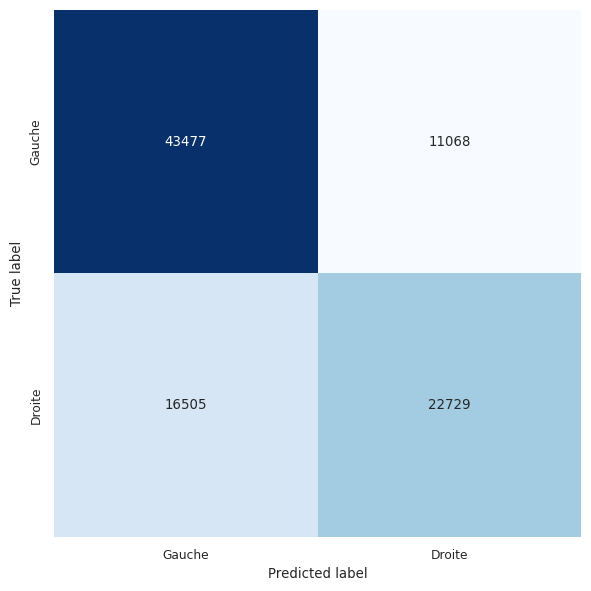

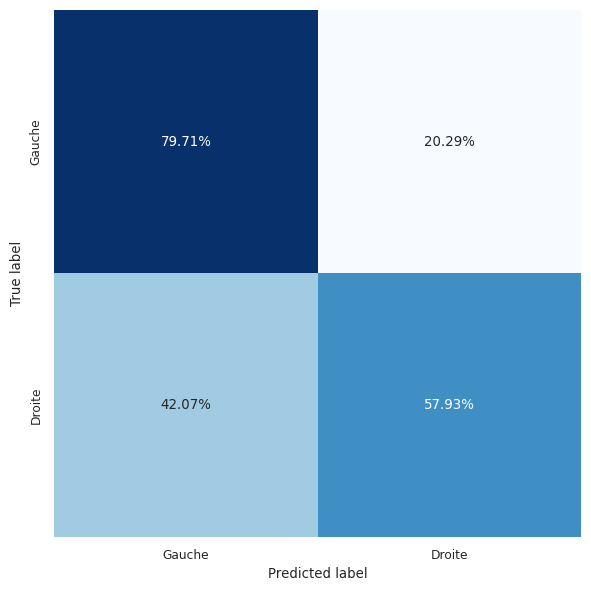

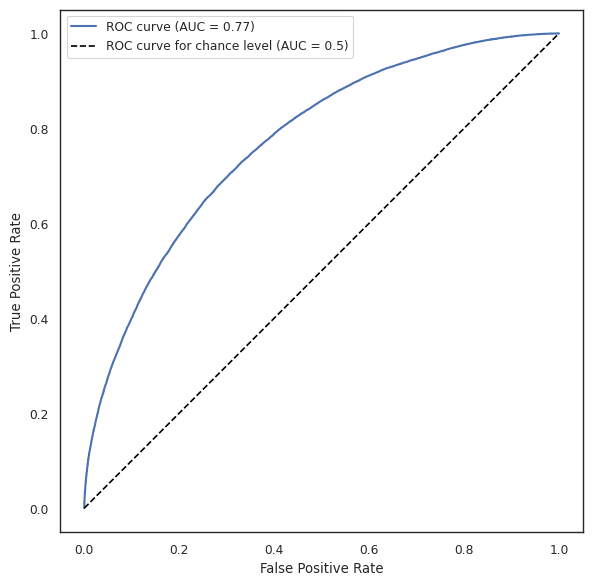

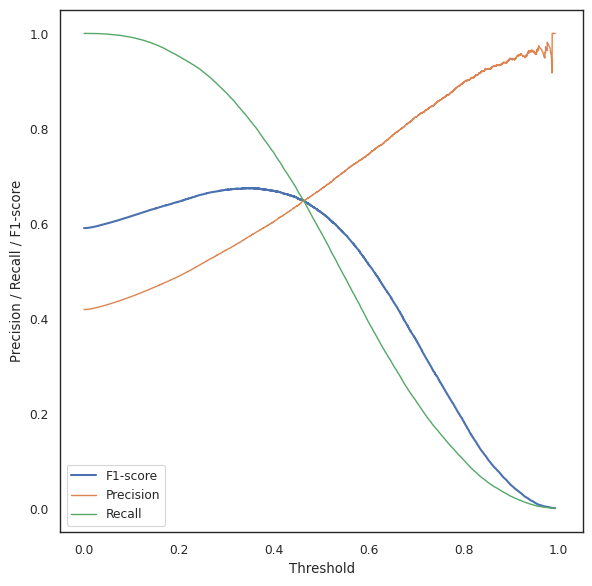

In [13]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Compare metrics

In [27]:
def parse_tensorboard(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()

    scalars = ea.Tags()["scalars"]

    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [29]:
EVENT_FILES = glob("../../results/optimizer_selection/**/lightning_logs/version_*")

In [99]:
res_dict = {}

for f in EVENT_FILES:
    name = Path(f).parent.parent.name
    tmp = parse_tensorboard(f)
    res_dict[name] = tmp

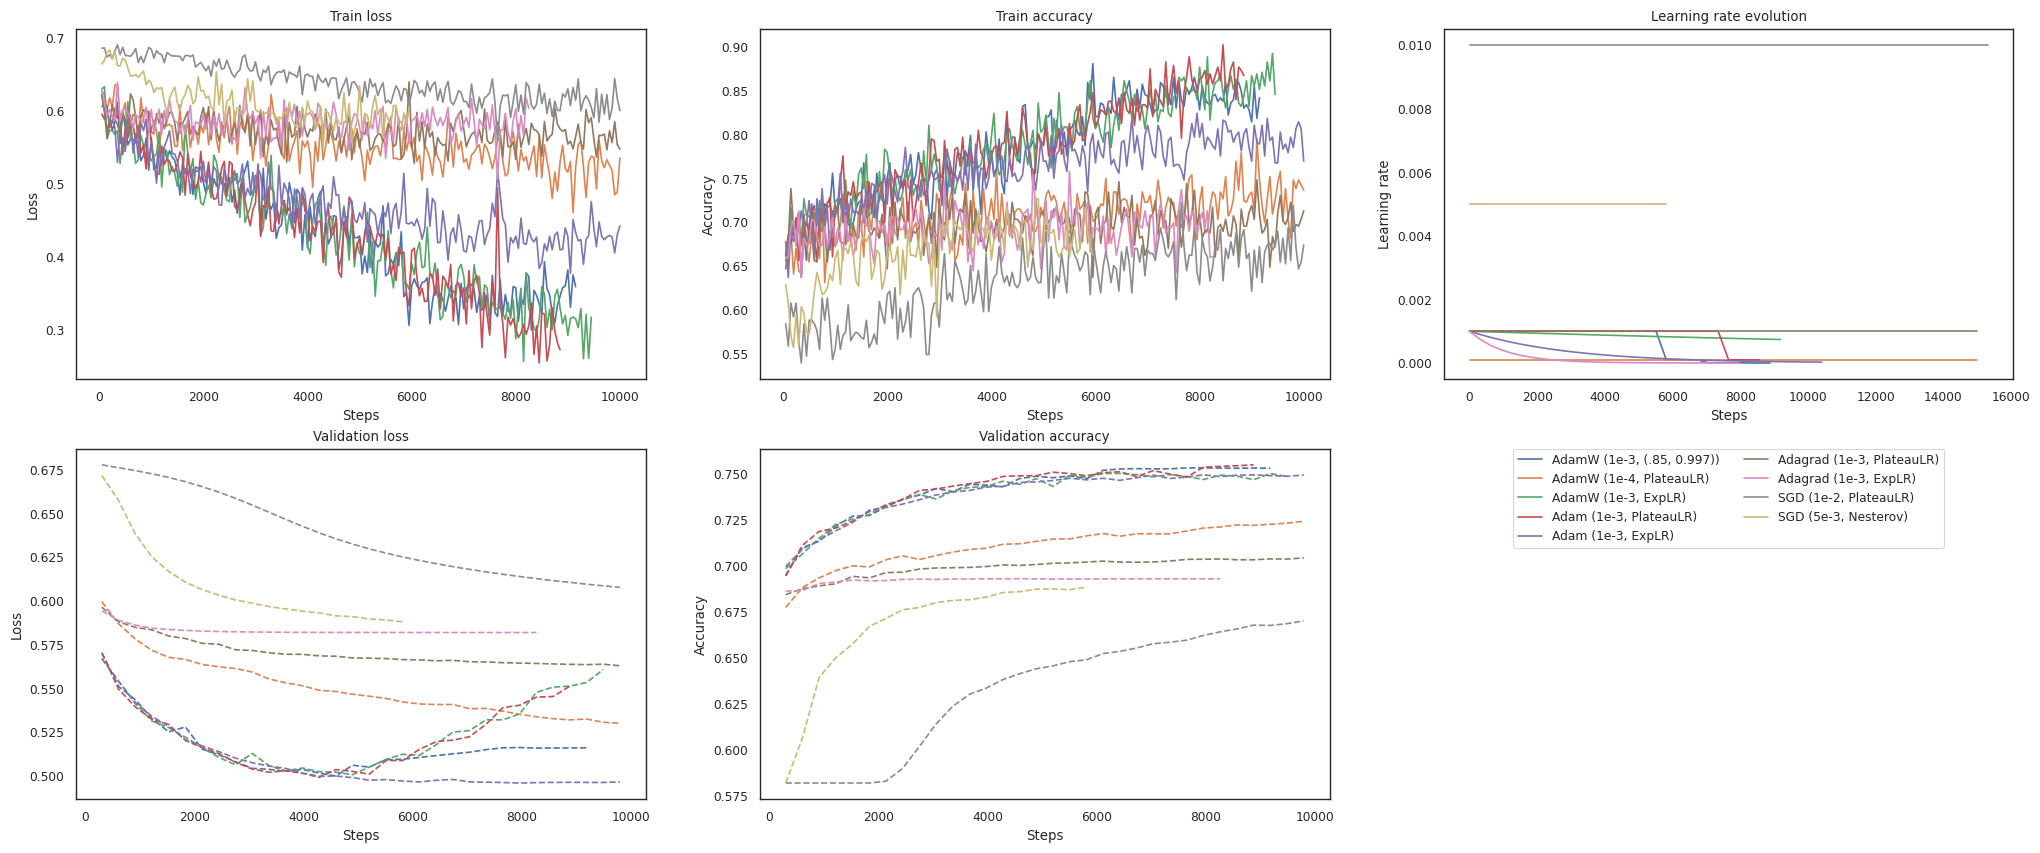

In [135]:
models = {
    "AdamW_0.001_(0.85, 0.997)": "AdamW (1e-3, (.85, 0.997))",
    "AdamW_0.0001_(0.99, 0.999)": "AdamW (1e-4, PlateauLR)",
    "AdamW_0.001_ExponentialLR": "AdamW (1e-3, ExpLR)",
    "Adam_0.001_ReduceLROnPlateau": "Adam (1e-3, PlateauLR)",
    "Adam_0.001_ExponentialLR-0.9": "Adam (1e-3, ExpLR)",
    "Adagrad_0.001_ReduceLROnPlateau": "Adagrad (1e-3, PlateauLR)",
    "Adagrad_0.001_ExponentialLR": "Adagrad (1e-3, ExpLR)",
    "SGD_0.01_ReduceLROnPlateau": "SGD (1e-2, PlateauLR)",
    "SGD_0.005_NESTEROV": "SGD (5e-3, Nesterov)",
}
res_dict_2 = {k: res_dict[k] for k in models}


fig, axs = plt.subplots(2, 3, figsize=(25, 10))

colors = sns.color_palette("deep", len(res_dict))
max_step = 10000

for i, model in enumerate(res_dict_2):
    tmp = res_dict_2[model]

    for k in ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]:
        tmp[k] = tmp[k][tmp[k]["step"] < max_step]

    train_steps = tmp["train_loss"]["step"]
    train_loss = tmp["train_loss"]["value"]
    val_steps = tmp["val_loss"]["step"]
    val_loss = tmp["val_loss"]["value"]
    train_acc = tmp["train_accuracy"]["value"]
    val_acc = tmp["val_accuracy"]["value"]
    lr_key = list(tmp.keys())[1]
    lr_steps = tmp[lr_key]["step"]
    lr_val = tmp[lr_key]["value"]

    axs[0, 0].plot(train_steps, train_loss, label=models[model], color=colors[i])
    axs[1, 0].plot(val_steps, val_loss, color=colors[i], linestyle="--")
    axs[0, 0].set(xlabel="Steps", ylabel="Loss", title="Train loss")
    axs[1, 0].set(xlabel="Steps", ylabel="Loss", title="Validation loss")

    axs[0, 1].plot(train_steps, train_acc, label=models[model], color=colors[i])
    axs[1, 1].plot(val_steps, val_acc, color=colors[i], linestyle="--")
    axs[0, 1].set(xlabel="Steps", ylabel="Accuracy", title="Train accuracy")
    axs[1, 1].set(xlabel="Steps", ylabel="Accuracy", title="Validation accuracy")

    axs[0, 2].plot(lr_steps, lr_val, label=models[model], color=colors[i])
    axs[0, 2].set(xlabel="Steps", ylabel="Learning rate", title="Learning rate evolution")
    axs[0, 2].legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)

    axs[1, 2].axis("off")

fig.savefig("../../results/optimizer_selection/loss_evolution.png")

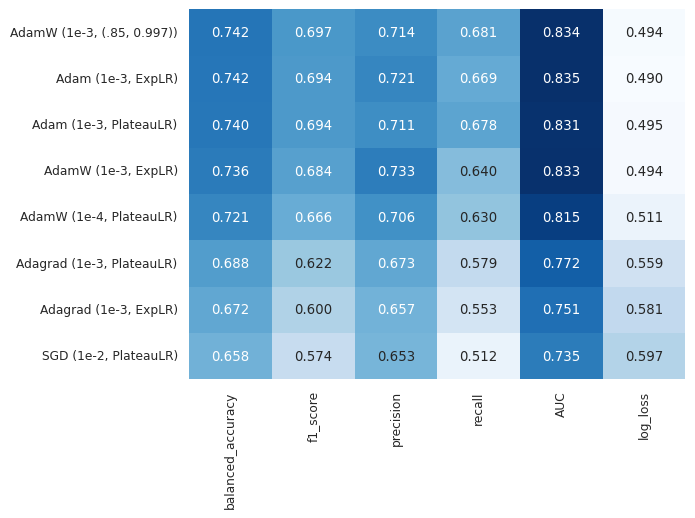

In [136]:
metrics = []

metrics_files = glob("../../results/optimizer_selection/**/metrics.json")
metrics_files = [Path(f) for f in metrics_files]

model_index = [f for f in metrics_files if f.parent.name in models]
model_names = [models[m.parent.name] for m in model_index]

for f in model_index:
    with open(f, "r") as file:
        metrics.append(json.load(file))

res_df = pd.DataFrame(metrics, index=model_names)

g = sns.heatmap(
    res_df[["balanced_accuracy", "f1_score", "precision", "recall", "AUC", "log_loss"]].sort_values(
        "f1_score", ascending=False
    ),
    annot=True,
    fmt=".3f",
    cmap="Blues",
    cbar=False,
)

g.figure.savefig("../../results/optimizer_selection/heatmap.png")